In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import Input
from tensorflow.keras import utils
from tensorflow.keras import datasets
from tensorflow.keras import preprocessing
from tensorflow.keras import metrics
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend

from pylab import rcParams
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

In [70]:
train_path = 'data/train_images_resized'
test_path = 'data/test_images_resized'

df = pd.read_csv('data/train.csv')
df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [71]:
df.shape

(18632, 2)

In [72]:
dct = defaultdict(list)

for i, label in enumerate(df.labels):
    for category in label.split():
        dct[category].append(i)

dct = {key: np.array(val) for key, val in dct.items()}
dct

{'healthy': array([    0,     5,     7, ..., 18626, 18627, 18631]),
 'scab': array([    1,     2,     3, ..., 18625, 18628, 18630]),
 'frog_eye_leaf_spot': array([    1,    14,    31, ..., 18612, 18619, 18630]),
 'complex': array([    1,     4,     8, ..., 18597, 18604, 18617]),
 'rust': array([    6,    21,    26, ..., 18601, 18616, 18629]),
 'powdery_mildew': array([   20,    39,    44, ..., 18532, 18617, 18618])}

In [73]:
new_df = pd.DataFrame(np.zeros((df.shape[0], len(dct.keys())), dtype = np.int8), columns = dct.keys())

for key, val in dct.items():
    new_df.loc[val, key] = 1

new_df.head()

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,1,0,0,0,0,0
1,0,1,1,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0


In [74]:
new_df.sum(axis = 0)

healthy               4624
scab                  5712
frog_eye_leaf_spot    4352
complex               2151
rust                  2077
powdery_mildew        1271
dtype: int64

In [75]:
from collections import Counter

Counter(df.labels)

Counter({'healthy': 4624,
         'scab frog_eye_leaf_spot complex': 200,
         'scab': 4826,
         'complex': 1602,
         'rust': 1860,
         'frog_eye_leaf_spot': 3181,
         'powdery_mildew': 1184,
         'scab frog_eye_leaf_spot': 686,
         'frog_eye_leaf_spot complex': 165,
         'rust frog_eye_leaf_spot': 120,
         'powdery_mildew complex': 87,
         'rust complex': 97})

In [76]:
ks = {k: i for i,k in enumerate(Counter(df.labels).keys())}
new_df['labs'] = np.array([ks[v] for v in df.labels])
new_df['labs']

0        0
1        1
2        2
3        2
4        3
        ..
18627    0
18628    2
18629    4
18630    7
18631    0
Name: labs, Length: 18632, dtype: int64

In [77]:
new_df = pd.concat([df, new_df], axis = 1)

new_df.head()

,image,labels,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew,labs
0,800113bb65efe69e.jpg,healthy,1,0,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,1,1,1,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,0,1,0,0,0,0,2
3,80077517781fb94f.jpg,scab,0,1,0,0,0,0,2
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0,3


In [78]:
target_columns = list(new_df.columns[2:-1])

target_columns

['healthy', 'scab', 'frog_eye_leaf_spot', 'complex', 'rust', 'powdery_mildew']

In [79]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    recall = true_positives / (possible_positives + backend.epsilon())
    f1_val = 2*(precision * recall)/(precision+recall+ backend.epsilon())
    return f1_val


In [80]:
def extend_network(base_model, number_of_class):

    # prediction layers
    gap = layers.GlobalAveragePooling2D()
    fc_1 = layers.Dense(number_of_class, activation='sigmoid', name='predictions')

    # create new model object
    new_model = models.Sequential(name="new_model")

    # add prediction layers to new model object
    new_model.add(base_model)
    new_model.add(gap)
    new_model.add(fc_1)

    # define optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)

    # compile new model
    new_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1])

    return new_model

In [81]:
network_size = (299,299)
number_of_classes = 6

In [82]:
# with include_top = False, you can pull just CNNs not FC layers. We use Xception as backbone
base_model = Xception(include_top = False, weights= "imagenet", input_shape = (299,299,3))

In [83]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [84]:
# extend the network with FC layers
new_model = extend_network(base_model=base_model, number_of_class=number_of_classes)
new_model.summary()

Model: "new_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 20,819,246
Non-trainable params: 54,528
_________________________________________________________________


In [85]:
batch_size = 16
image_generator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    
    rotation_range=30, 
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    vertical_flip=False,
    fill_mode="reflect"
  )



new_df = new_df.iloc[np.random.choice(new_df.shape[0], new_df.shape[0], replace = False),:]

skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 1488)

train_ind, test_ind = next(skf.split(new_df, new_df['labs']))

train_generator = image_generator.flow_from_dataframe(
    dataframe = new_df.iloc[train_ind,:],
    directory = train_path,
    x_col="image",
    y_col = target_columns,
    weight_col=None,
    target_size = network_size,
    color_mode="rgb",
    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=None
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe = new_df.iloc[test_ind,:],
    directory = train_path,
    x_col="image",
    y_col = target_columns,
    weight_col=None,
    target_size = network_size,
    color_mode="rgb",
    class_mode="raw",
    batch_size=batch_size,
    shuffle=False,
    seed=None
)

Found 16303 validated image filenames.
Found 2329 validated image filenames.


In [86]:
batch = next(validation_generator)

print(batch[1].shape)

(16, 6)


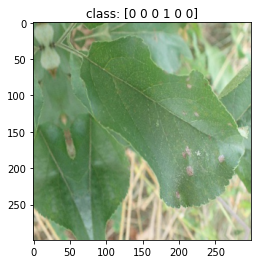

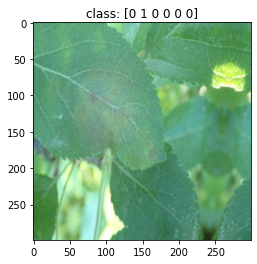

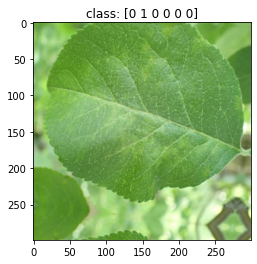

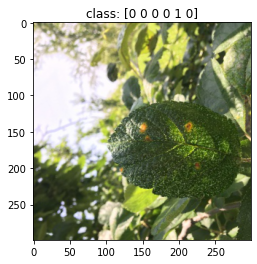

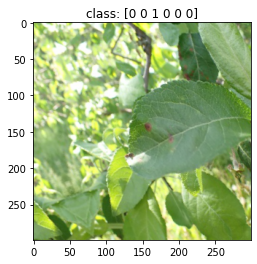

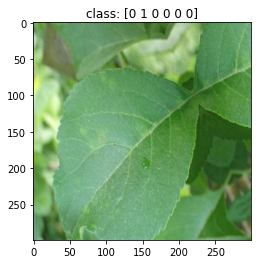

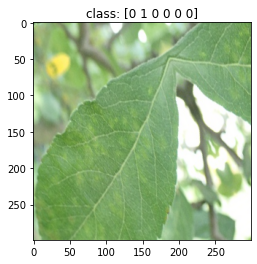

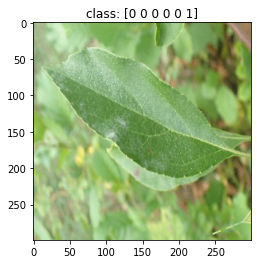

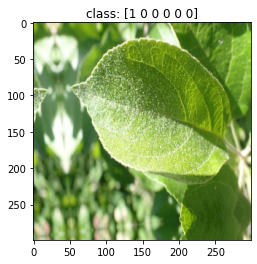

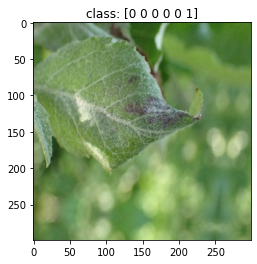

In [87]:
for i in range(10):
    plt.imshow(batch[0][i,:,:,:])
    cl = batch[1][i]
    plt.title(f'class: {cl}')
    plt.show()

In [88]:
# if val_accuracy value does not increase for four epochs, then stop the training
earlyStopping = EarlyStopping(monitor='val_f1', patience=5, verbose=0, mode='max')

# save best model only
mcp_save = ModelCheckpoint('model_xception_best.h5', save_best_only=True, 
                           monitor='val_f1', mode='max')
    
# train the network
res = new_model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        epochs=30,
        callbacks=[earlyStopping, mcp_save])

/home/berkant/anaconda3/envs/lazyprogrammer/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1019/1019 [==============================] - 1397s 1s/step - loss: 0.2147 - f1: 0.7441 - val_loss: 0.2381 - val_f1: 0.6836
Epoch 2/30
1019/1019 [==============================] - 1505s 1s/step - loss: 0.1348 - f1: 0.8502 - val_loss: 0.1256 - val_f1: 0.8613
Epoch 3/30
1019/1019 [==============================] - 1621s 2s/step - loss: 0.1180 - f1: 0.8693 - val_loss: 0.1245 - val_f1: 0.8529
Epoch 4/30
1019/1019 [==============================] - 1651s 2s/step - loss: 0.1124 - f1: 0.8744 - val_loss: 0.1250 - val_f1: 0.8661
Epoch 5/30
1019/1019 [==============================] - 1670s 2s/step - loss: 0.1065 - f1: 0.8761 - val_loss: 0.1220 - val_f1: 0.8633
Epoch 6/30
1019/1019 [==============================] - 1655s 2s/step - loss: 0.0964 - f1: 0.8923 - val_loss: 0.1111 - val_f1: 0.8788
Epoch 7/30
1019/1019 [==============================] - 1691s 2s/step - loss: 0.0954 - f1: 0.8921 - val_loss: 0.1248 - val_f1: 0.8630
Epoch 8/30
1019/1019 [==============================] - 1659s 

In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8310105003390329498
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5467340800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9362607650210095456
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
